## Imports

In [3]:
# !conda activate n2v
%load_ext autoreload

import numpy as np
from matplotlib import pyplot as plt
import sys
import random
import zarr
from PIL import Image
from skimage import data
from skimage import filters
from skimage import metrics
import os

import gunpowder as gp
import logging
logging.basicConfig(level=logging.INFO)

# from this repo
# from segway.tasks.make_zarr_from_tiff import task_make_zarr_from_tiff_volume as tif2zarr
from boilerPlate import GaussBlur

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
# ADD HELPER FUNCTIONS

def noise_pipe(src, target, pipeline, noise_order, noise_dict):
    this_array = src
    for noise in noise_order:
        if noise_dict[noise]:
            if noise =='downX' and noise_dict[noise]:
                pipeline += gp.DownSample(src, (1, noise_dict[noise], noise_dict[noise]), target) # assumes zyx coordinates (and non-isometric)
                this_array = target
            elif noise =='gaussBlur' and noise_dict[noise]:
                pipeline += GaussBlur(this_array, noise_dict[noise])
            elif noise =='gaussNoise' and noise_dict[noise]:
                pipeline += gp.NoiseAugment(this_array, mode='gaussian', var=noise_dict[noise])
            elif noise =='poissNoise' and noise_dict[noise]:
                pipeline += gp.NoiseAugment(this_array, mode='poisson')
            # elif noise =='deform' and noise_dict[noise]: # TODO: IMPLEMENT
            #     pipeline += ...

    return pipeline

# Specify Parameters (source, noise type, downsampling, etc.)

In [146]:
noise_version = '' # for making multiple independently generated noise versions (e.g. for Fourier Shell analysis)
src_path = '/n/groups/htem/ESRF_id16a/tomo_ML/synapse/cb2/volumes/' # PATH FOR ZARR

raw_name = 'raw'
noise_dict = {'downX': 8, # cudegy mimic of 30nm pixel size (max uttained) from sensor at ESRF.i16a X-ray source, assuming 4nm voxel size EM source images
         'gaussBlur': 15, # cudegy mimic of 30nm resolution of KB mirrors at ESRF.i16a X-ray source
         'gaussNoise': None, # ASSUMES MEAN = 0, THIS SETS VARIANCE
         'poissNoise': True, # cudegy mimic of sensor shot noise (hot pixels) at ESRF.i16a X-ray source
        #  'deform': , # TODO: IMPLEMENT
         }

# noise_order = [
#                 #'gaussBlur', 
#                'downX', 
#                'gaussNoise', 
#                'poissNoise'
#                ]

noise_order = ['downX', 
               'gaussBlur', 
               'gaussNoise', 
               'poissNoise'
               ]

samples = [
    'ml0', # should be already done
    'ml1',
    'cutout1',
    'cutout2',
    'cutout5',
    'cutout6',
    'cutout7',
    ]

src_voxel_size = (40, 4, 4)

In [147]:
##### BELOW IS AUTOMATIC PARAMETER SETUP BASED ON ABOVE SPECIFICATIONS ######

noise_name = ''
for noise in noise_order:
    if noise_dict[noise]:
        if str(noise_dict[noise]).isnumeric():
            noise_name += noise + str(noise_dict[noise]) + '_'
        elif isinstance(noise_dict[noise], bool):
            noise_name += noise + '_'

if noise_version == '':
    noise_name = noise_name[:-1]
else:
    noise_name += noise_version

print('Layer name for noised data: ' + noise_name)

if noise_dict['downX']:
    dest_voxel_size = [src_voxel_size[s] * noise_dict['downX'] if s > 0 else src_voxel_size[s] for s in range(len(src_voxel_size))]
else:
    dest_voxel_size = src_voxel_size
src_voxel_size = gp.Coordinate(src_voxel_size)
dest_voxel_size = gp.Coordinate(dest_voxel_size)


Layer name for noised data: downX1_gaussBlur15_poissNoise


# Check out raw data

In [28]:
sample = samples[0]
src = f'{src_path}{sample}/{sample}.zarr/volumes'
data = zarr.open(src)

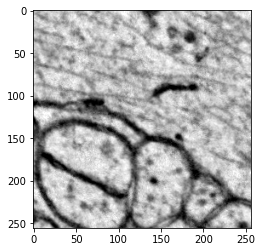

In [30]:
#pick indices/window
window = 256
x_off = 100
y_off = 100
z_off = 10
plt.imshow(data['raw'][z_off, y_off:y_off+window, x_off:x_off+window], cmap='gray')

# Setup Noising Pipeline

In [127]:
%autoreload
from boilerPlate import GaussBlur

### Test pipeline before saving:

In [148]:
#pick a sample
sample = samples[0]

# declare arrays to use in the pipeline
raw = gp.ArrayKey('RAW') # raw data
noisy = gp.ArrayKey('NOISY') # data noise added
raw_spec = gp.ArraySpec(voxel_size=src_voxel_size, interpolatable=True)

# request matching the model input and output sizes
request = gp.BatchRequest()
request.add(raw, (40,1024, 1024))#, src_voxel_size)
request.add(noisy, (40, 1024, 1024))#, dest_voxel_size)

src = f'{src_path}{sample}/{sample}.zarr/volumes'
zarr.open(src)
source = gp.ZarrSource(    # add the data source
        src,  # the zarr container
        {raw: raw_name},  # which dataset to associate to the array key
        {raw: raw_spec}  # meta-information
)

# add normalization
normalize = gp.Normalize(raw)

# add a RandomLocation node to the pipeline to randomly select a sample
random_location = gp.RandomLocation()

proto_pipe = source + normalize + random_location

pipeline = noise_pipe(raw, noisy, proto_pipe, noise_order, noise_dict)

with gp.build(pipeline):
        batch = pipeline.request_batch(request)

True


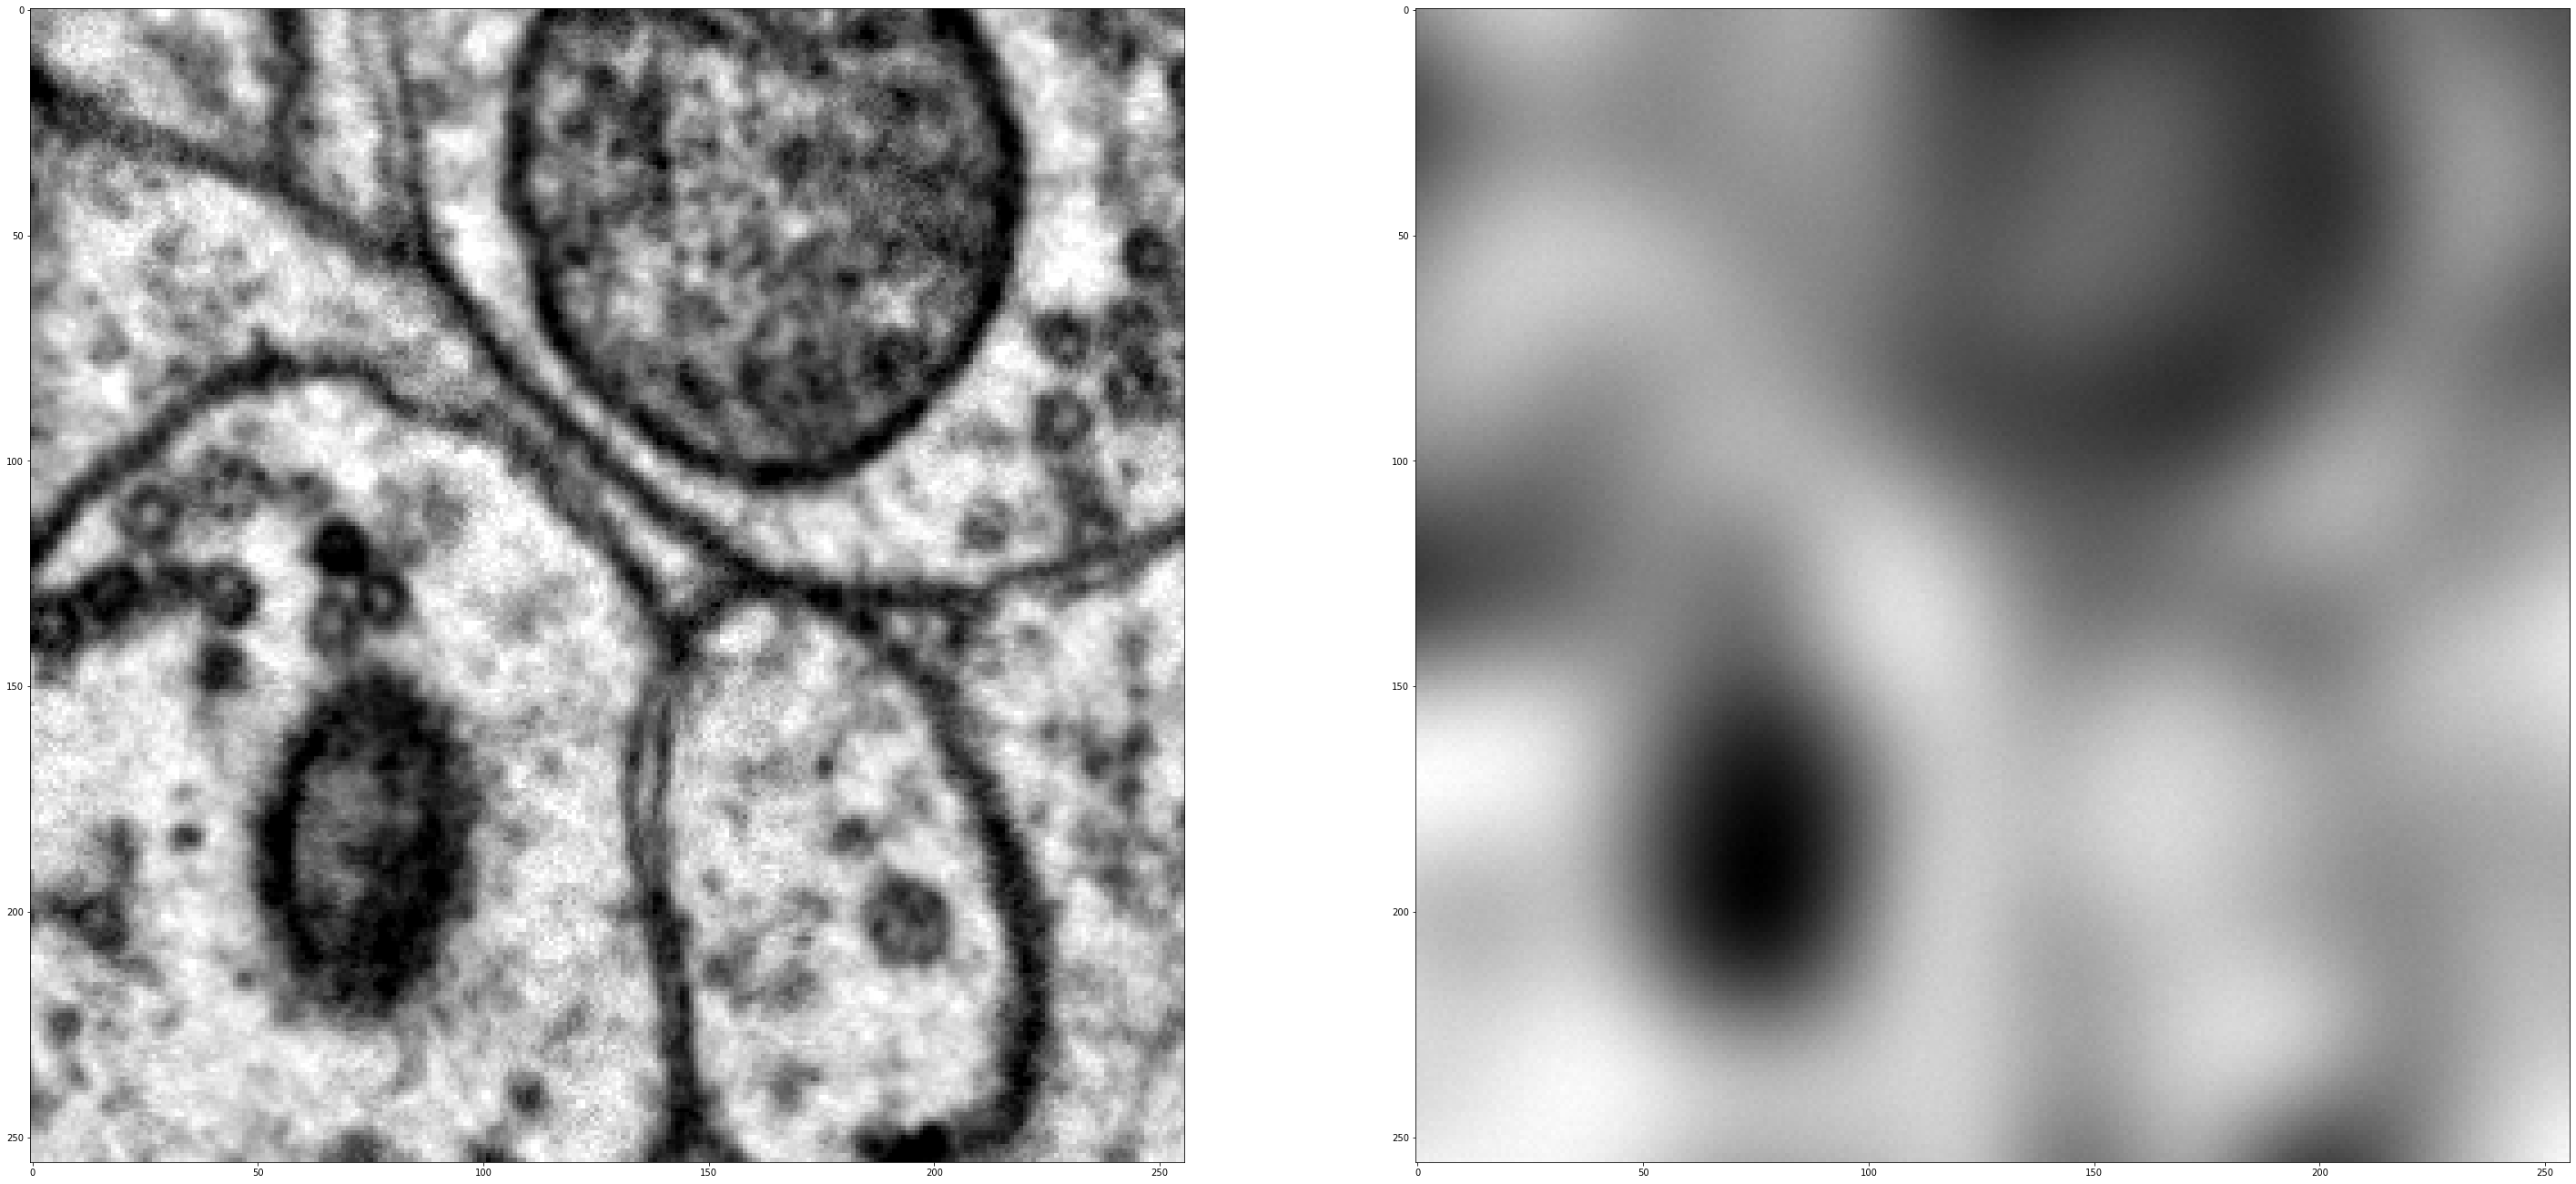

In [149]:
fig, axs = plt.subplots(1,2, figsize=(50,100))
axs[0].imshow(batch[raw].data.squeeze(), cmap='gray')
axs[1].imshow(batch[noisy].data.squeeze(), cmap='gray')

### Run actual

In [25]:
# assemble pipeline for each volume and run
for sample in samples:    
        # declare arrays to use in the pipeline
        raw = gp.ArrayKey('RAW') # raw data
        noisy = gp.ArrayKey('NOISY') # data noise added
        raw_spec = gp.ArraySpec(voxel_size=src_voxel_size, interpolatable=True)

        stack = gp.Stack(8)

        # request matching the model input and output sizes
        scan_request = gp.BatchRequest()
        scan_request.add(raw, (40, 256, 256))#, src_voxel_size)
        scan_request.add(noisy, (40, 256, 256))#, dest_voxel_size)

        scan = gp.Scan(scan_request, num_workers=os.cpu_count())

        # request an empty batch from scan
        request = gp.BatchRequest()

        # setup Cache
        cache = gp.PreCache()

        # get performance stats
        performance = gp.PrintProfilingStats(every=100)
        # $src_path$volume/$volume.zarr/volumes/$layer
        src = f'{src_path}{sample}/{sample}.zarr/volumes'
        zarr.open(src)
        source = gp.ZarrSource(    # add the data source
                src,  # the zarr container
                {raw: raw_name},  # which dataset to associate to the array key
                {raw: raw_spec}  # meta-information
        )

        destination = gp.ZarrWrite(
                dataset_names = {noisy: noise_name},
                output_dir = f'{src_path}{sample}',
                output_filename = f'{sample}.zarr/volumes',
                #dataset_dtypes = {noisy: np.uint8} # save as 0-255 values (should match raw)
        )

        # add normalization
        normalize = gp.Normalize(raw)

        proto_pipe = source + normalize

        pipeline = (noise_pipe(raw, noisy, proto_pipe, noise_order, noise_dict) + 
                        cache +
                        stack + 
                        destination + 
                        scan + 
                        performance)
        
        with gp.build(pipeline):
                pipeline.request_batch(request)
                print('Finished: ' + src)

INFO:gunpowder.nodes.scan:scanning over 204800 chunks
100%|██████████| 204800/204800 [1:05:43<00:00, 51.93it/s]INFO:gunpowder.producer_pool:terminating workers...
INFO:gunpowder.producer_pool:joining workers...

INFO:gunpowder.producer_pool:done


Finished: /n/groups/htem/ESRF_id16a/tomo_ML/synapse/cb2/cutout6/cutout6.zarr/volumes


INFO:gunpowder.nodes.scan:scanning over 204800 chunks
ERROR:gunpowder.producer_pool:Exception in ZarrWrite while processing request
	RAW: ROI: [120:160, 0:256, 0:256] (40, 256, 256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	NOISY: ROI: [120:160, 0:256, 0:256] (40, 256, 256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
 
Batch returned so far:
None
Traceback (most recent call last):
  File "/mnt/orchestra_nfs/users/jlr54/envs/miniconda3/envs/n2v/lib/python3.7/site-packages/gunpowder/nodes/batch_provider.py", line 188, in request_batch
    batch = self.provide(upstream_request)
  File "/mnt/orchestra_nfs/users/jlr54/envs/miniconda3/envs/n2v/lib/python3.7/site-packages/gunpowder/nodes/batch_filter.py", line 182, in provide
    processed_batch = self.process(node_batch, downstream_request)
  File "/mnt/orchestra_nfs/users/jlr54/envs/miniconda3/envs/n2v/lib/python3.7/site-packages/gunpowder/n

PipelineRequestError: Exception in pipeline:
ZarrSource[/n/groups/htem/ESRF_id16a/tomo_ML/synapse/cb2/cutout7/cutout7.zarr/volumes] -> GaussBlur -> DownSample -> NoiseAugment -> ZarrWrite -> Scan -> PrintProfilingStats
while trying to process request



In [19]:
test = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/synapse/cb2/volumes/cutout1/cutout1.zarr/volumes')
noised = test[noise_name]
test.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,2
No. groups,1
Arrays,"gaussBlur30_downX8_poissNoise, raw"
Groups,labels


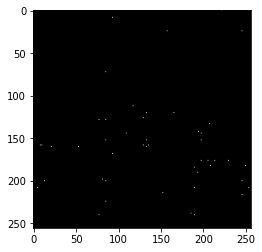

In [20]:
plt.imshow(noised[0,:,:], cmap='gray', vmin=np.min(noised), vmax=np.max(noised))

In [15]:
np.max(noised)

1